In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")

In [3]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")
#external_validation_cohort = pd.read_csv("processed_ecgs_all.csv")

In [4]:
y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

y_test = external_validation_cohort['Outcome_Occlusion_MI']
X_test = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)
#y_test = external_validation_cohort['OMI']
#X_test = external_validation_cohort.drop(['OMI', 'patient_1'], axis=1)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_106764\3344725180.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_106764\3344725180.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [5]:
clf = GradientBoostingClassifier(
    n_estimators=109,
    learning_rate=0.1,  # Default is 0.1, can be tuned
    max_depth=3,  # Typical default value, adjust if needed
    min_samples_split=10,  # Adjusted based on RF min_samples_split
    min_samples_leaf=5,  # Adjusted based on RF min_samples_leaf
    subsample=0.75,  # Equivalent to max_samples=0.75
    random_state=42
)

# Optional calibration
clf = CalibratedClassifierCV(clf, cv=5, method="isotonic")

In [6]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'GBM (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [8]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm
import pandas as pd

# Define the parameter grid for GBM
param_grid = {
    'n_estimators': [100, 125, 150],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [2, 3, 4],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [5, 7],
    'subsample': [0.9, 1.0]
}

print("Hyperparameter Tuning for GBM with 10-Fold Cross-Validation")
print("Searching for optimal hyperparameters using AUROC metric...")

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_mean_auroc = 0
best_params = {}
best_model = None
use_calibration = False

# Calculate total number of parameter combinations
total_combinations = (len(param_grid['n_estimators']) * 
                      len(param_grid['learning_rate']) * 
                      len(param_grid['max_depth']) * 
                      len(param_grid['min_samples_split']) * 
                      len(param_grid['min_samples_leaf']) * 
                      len(param_grid['subsample']))
                      
print(f"Total parameter combinations to try: {total_combinations}")

# Store results for later analysis
results_list = []

# Setup progress bar
pbar = tqdm(total=total_combinations)

# Loop through all parameters
for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    for subsample in param_grid['subsample']:
                        try:
                            # Lists to store base and calibrated model AUROC for each fold
                            base_fold_aurocs = []
                            calibrated_fold_aurocs = []
                            
                            # Perform cross-validation
                            for train_idx, val_idx in cv.split(X_train, y_train):
                                # Split data for this fold - make sure to handle different data types appropriately
                                if isinstance(X_train, np.ndarray):
                                    # For numpy arrays
                                    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                                    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                                elif isinstance(X_train, pd.DataFrame):
                                    # For pandas DataFrame
                                    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                                    if isinstance(y_train, pd.Series):
                                        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                                    else:
                                        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                                else:
                                    # Fallback option
                                    X_fold_train = [X_train[i] for i in train_idx]
                                    X_fold_val = [X_train[i] for i in val_idx]
                                    y_fold_train = [y_train[i] for i in train_idx]
                                    y_fold_val = [y_train[i] for i in val_idx]
                                
                                # Create and train base GBM model with current parameters
                                base_gbm = GradientBoostingClassifier(
                                    n_estimators=n_estimators,
                                    learning_rate=learning_rate,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    subsample=subsample,
                                    random_state=42
                                )
                                base_gbm.fit(X_fold_train, y_fold_train)
                                
                                try:
                                    # Evaluate base model
                                    base_val_probas = base_gbm.predict_proba(X_fold_val)[:, 1]
                                    if np.isnan(base_val_probas).any():
                                        continue
                                    
                                    base_auroc = roc_auc_score(y_fold_val, base_val_probas)
                                    base_fold_aurocs.append(base_auroc)
                                    
                                    # Create and evaluate calibrated model
                                    calibrated_gbm = CalibratedClassifierCV(
                                        base_gbm, 
                                        cv='prefit',  # Use prefit since we already trained the base model
                                        method="isotonic"
                                    )
                                    # Use a small portion of validation set for calibration
                                    # (in real CV we'd use a separate subset, but for simplicity we'll use the validation set)
                                    calibrated_gbm.fit(X_fold_val, y_fold_val)
                                    
                                    cal_val_probas = calibrated_gbm.predict_proba(X_fold_val)[:, 1]
                                    cal_auroc = roc_auc_score(y_fold_val, cal_val_probas)
                                    calibrated_fold_aurocs.append(cal_auroc)
                                    
                                except Exception as e:
                                    print(f"Error evaluating fold: {e}")
                                    continue
                            
                            # Only proceed if we have valid results from all folds
                            if len(base_fold_aurocs) == 10 and len(calibrated_fold_aurocs) == 10:
                                # Calculate mean and standard deviation for both base and calibrated models
                                base_mean_auroc = np.mean(base_fold_aurocs)
                                base_std_auroc = np.std(base_fold_aurocs)
                                
                                cal_mean_auroc = np.mean(calibrated_fold_aurocs)
                                cal_std_auroc = np.std(calibrated_fold_aurocs)
                                
                                # Determine which model (base or calibrated) performed better on average
                                if cal_mean_auroc > base_mean_auroc:
                                    current_mean_auroc = cal_mean_auroc
                                    current_std_auroc = cal_std_auroc
                                    current_calibration = True
                                else:
                                    current_mean_auroc = base_mean_auroc
                                    current_std_auroc = base_std_auroc
                                    current_calibration = False
                                
                                print(f"Params: n_est={n_estimators}, lr={learning_rate}, depth={max_depth}, "
                                      f"min_split={min_samples_split}, min_leaf={min_samples_leaf}, subsample={subsample}")
                                print(f"Base CV AUROC={base_mean_auroc:.4f} ± {base_std_auroc:.4f}, "
                                      f"Calibrated CV AUROC={cal_mean_auroc:.4f} ± {cal_std_auroc:.4f}")
                                
                                # Store results
                                results_list.append({
                                    'n_estimators': n_estimators,
                                    'learning_rate': learning_rate,
                                    'max_depth': max_depth,
                                    'min_samples_split': min_samples_split,
                                    'min_samples_leaf': min_samples_leaf,
                                    'subsample': subsample,
                                    'base_mean_auroc': base_mean_auroc,
                                    'base_std_auroc': base_std_auroc,
                                    'cal_mean_auroc': cal_mean_auroc,
                                    'cal_std_auroc': cal_std_auroc,
                                    'best_mean_auroc': current_mean_auroc,
                                    'use_calibration': current_calibration
                                })
                                
                                # Track best model based on mean AUROC
                                if current_mean_auroc > best_mean_auroc:
                                    best_mean_auroc = current_mean_auroc
                                    best_params = {
                                        'n_estimators': n_estimators,
                                        'learning_rate': learning_rate,
                                        'max_depth': max_depth,
                                        'min_samples_split': min_samples_split,
                                        'min_samples_leaf': min_samples_leaf,
                                        'subsample': subsample,
                                        'use_calibration': current_calibration
                                    }
                            
                        except Exception as e:
                            print(f"Error processing combination: {e}")
                        
                        # Update progress bar
                        pbar.update(1)

pbar.close()

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results_list)

# Print final results summary
if len(results_df) > 0:
    print("\n" + "="*50)
    print("\nTop 5 parameter combinations:")
    print(results_df.sort_values('best_mean_auroc', ascending=False).head(5)[
        ['n_estimators', 'learning_rate', 'max_depth', 'min_samples_split', 
         'min_samples_leaf', 'subsample', 'best_mean_auroc', 'use_calibration']
    ])
    
    print("\n" + "="*50)
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation AUROC: {best_mean_auroc:.4f}")
    
    # Create the final model using the best parameters
    final_base_gbm = GradientBoostingClassifier(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        subsample=best_params['subsample'],
        random_state=42
    )
    
    # Train on the full training set
    final_base_gbm.fit(X_train, y_train)
    
    if best_params.get('use_calibration', False):
        print("Using calibrated model with isotonic calibration")
        # If we're using calibration, we need to calibrate on some data
        # In a real-world scenario, you might want to use a separate calibration set
        # For simplicity, we'll use the training data (though this risks overfitting)
        final_calibrated_gbm = CalibratedClassifierCV(
            final_base_gbm, 
            cv='prefit',
            method="isotonic"
        )
        # In practice, you would want to use a separate calibration set
        # This is a simplification
        if 'X_val' in locals() and 'y_val' in locals():
            print("Calibrating on validation set")
            final_calibrated_gbm.fit(X_val, y_val)
        else:
            print("Calibrating on a subset of training set (not ideal)")
            from sklearn.model_selection import train_test_split
            X_cal, _, y_cal, _ = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
            final_calibrated_gbm.fit(X_cal, y_cal)
        
        clf = final_calibrated_gbm
    else:
        print("Using base GBM model without calibration")
        clf = final_base_gbm
    
    # Save the best model
    import joblib
    joblib.dump(clf, 'best_gbm_model.pkl')
    print("Best model saved as 'best_gbm_model.pkl'")
    
    # If you want to evaluate the best model on a test set (if available)
    if 'X_test' in locals() and 'y_test' in locals():
        test_probas = clf.predict_proba(X_test)[:, 1]
        test_auroc = roc_auc_score(y_test, test_probas)
        print(f"Test set AUROC for best model: {test_auroc:.4f}")
    
    # Visualize the results
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create a plot showing the impact of learning rate and n_estimators
    plt.figure(figsize=(12, 8))
    pivot = results_df.pivot_table(
        index='learning_rate', 
        columns='n_estimators',
        values='best_mean_auroc',
        aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis')
    plt.title('Mean AUROC by Learning Rate and N Estimators')
    plt.tight_layout()
    plt.savefig('gbm_lr_estimators_heatmap.png')
    
    # Create a plot showing the impact of max_depth and min_samples_split
    plt.figure(figsize=(12, 8))
    pivot = results_df.pivot_table(
        index='max_depth', 
        columns='min_samples_split',
        values='best_mean_auroc',
        aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis')
    plt.title('Mean AUROC by Max Depth and Min Samples Split')
    plt.tight_layout()
    plt.savefig('gbm_depth_split_heatmap.png')
    
else:
    print("\nNo valid models found. Check your data and evaluation criteria.")

Hyperparameter Tuning for GBM with 10-Fold Cross-Validation
Searching for optimal hyperparameters using AUROC metric...
Total parameter combinations to try: 216


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=2, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8680 ± 0.0599, Calibrated CV AUROC=0.8970 ± 0.0446


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=2, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8714 ± 0.0488, Calibrated CV AUROC=0.9013 ± 0.0351


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=2, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8717 ± 0.0543, Calibrated CV AUROC=0.9003 ± 0.0410


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=2, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8749 ± 0.0502, Calibrated CV AUROC=0.9035 ± 0.0369


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=2, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8639 ± 0.0614, Calibrated CV AUROC=0.8946 ± 0.0452


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=2, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8705 ± 0.0472, Calibrated CV AUROC=0.8988 ± 0.0359


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=2, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8730 ± 0.0524, Calibrated CV AUROC=0.9010 ± 0.0399


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=2, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8743 ± 0.0492, Calibrated CV AUROC=0.9035 ± 0.0366


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=3, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8813 ± 0.0513, Calibrated CV AUROC=0.9078 ± 0.0398


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=3, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8838 ± 0.0470, Calibrated CV AUROC=0.9114 ± 0.0334


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=3, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8743 ± 0.0462, Calibrated CV AUROC=0.9035 ± 0.0364


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=3, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8880 ± 0.0419, Calibrated CV AUROC=0.9138 ± 0.0319


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=3, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8794 ± 0.0509, Calibrated CV AUROC=0.9053 ± 0.0380


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=3, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8814 ± 0.0421, Calibrated CV AUROC=0.9077 ± 0.0348


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=3, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8794 ± 0.0546, Calibrated CV AUROC=0.9069 ± 0.0419


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=3, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8890 ± 0.0431, Calibrated CV AUROC=0.9151 ± 0.0330


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=4, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8688 ± 0.0557, Calibrated CV AUROC=0.8972 ± 0.0487


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=4, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8841 ± 0.0436, Calibrated CV AUROC=0.9104 ± 0.0337


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=4, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8753 ± 0.0520, Calibrated CV AUROC=0.9027 ± 0.0424


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=4, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8740 ± 0.0549, Calibrated CV AUROC=0.9028 ± 0.0420


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=4, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8742 ± 0.0523, Calibrated CV AUROC=0.9033 ± 0.0400


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=4, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8800 ± 0.0490, Calibrated CV AUROC=0.9064 ± 0.0397


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=4, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8736 ± 0.0489, Calibrated CV AUROC=0.9023 ± 0.0410


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.1, depth=4, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8832 ± 0.0531, Calibrated CV AUROC=0.9093 ± 0.0422


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=2, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8568 ± 0.0577, Calibrated CV AUROC=0.8890 ± 0.0423


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=2, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8586 ± 0.0525, Calibrated CV AUROC=0.8938 ± 0.0388


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=2, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8642 ± 0.0557, Calibrated CV AUROC=0.8951 ± 0.0425


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=2, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8708 ± 0.0601, Calibrated CV AUROC=0.9004 ± 0.0459


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=2, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8531 ± 0.0522, Calibrated CV AUROC=0.8842 ± 0.0426


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=2, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8663 ± 0.0521, Calibrated CV AUROC=0.8970 ± 0.0389


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=2, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8645 ± 0.0554, Calibrated CV AUROC=0.8949 ± 0.0423


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=2, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8694 ± 0.0603, Calibrated CV AUROC=0.8998 ± 0.0460


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=3, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8674 ± 0.0586, Calibrated CV AUROC=0.8997 ± 0.0460


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=3, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8764 ± 0.0565, Calibrated CV AUROC=0.9034 ± 0.0456


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=3, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8707 ± 0.0586, Calibrated CV AUROC=0.9003 ± 0.0453


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=3, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8781 ± 0.0548, Calibrated CV AUROC=0.9066 ± 0.0426


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=3, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8729 ± 0.0589, Calibrated CV AUROC=0.9000 ± 0.0470


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=3, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8767 ± 0.0499, Calibrated CV AUROC=0.9057 ± 0.0356


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=3, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8705 ± 0.0585, Calibrated CV AUROC=0.8999 ± 0.0451


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=3, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8833 ± 0.0549, Calibrated CV AUROC=0.9107 ± 0.0438


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=4, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8651 ± 0.0542, Calibrated CV AUROC=0.8965 ± 0.0444


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=4, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8862 ± 0.0344, Calibrated CV AUROC=0.9125 ± 0.0299


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=4, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8690 ± 0.0554, Calibrated CV AUROC=0.9007 ± 0.0413


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=4, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8715 ± 0.0543, Calibrated CV AUROC=0.9008 ± 0.0451


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=4, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8730 ± 0.0543, Calibrated CV AUROC=0.9024 ± 0.0434


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=4, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8769 ± 0.0503, Calibrated CV AUROC=0.9064 ± 0.0397


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=4, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8706 ± 0.0484, Calibrated CV AUROC=0.9019 ± 0.0404


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.2, depth=4, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8675 ± 0.0500, Calibrated CV AUROC=0.8986 ± 0.0407


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=2, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8469 ± 0.0423, Calibrated CV AUROC=0.8781 ± 0.0349


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=2, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8581 ± 0.0490, Calibrated CV AUROC=0.8906 ± 0.0414


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=2, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8523 ± 0.0724, Calibrated CV AUROC=0.8862 ± 0.0574


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=2, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8599 ± 0.0591, Calibrated CV AUROC=0.8932 ± 0.0472


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=2, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8429 ± 0.0480, Calibrated CV AUROC=0.8740 ± 0.0396


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=2, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8649 ± 0.0477, Calibrated CV AUROC=0.8949 ± 0.0403


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=2, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8429 ± 0.0739, Calibrated CV AUROC=0.8772 ± 0.0585


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=2, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8683 ± 0.0535, Calibrated CV AUROC=0.9000 ± 0.0425


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=3, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8603 ± 0.0570, Calibrated CV AUROC=0.8917 ± 0.0454


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=3, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8622 ± 0.0620, Calibrated CV AUROC=0.8929 ± 0.0510


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=3, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8594 ± 0.0610, Calibrated CV AUROC=0.8886 ± 0.0479


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=3, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8770 ± 0.0593, Calibrated CV AUROC=0.9050 ± 0.0483


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=3, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8583 ± 0.0595, Calibrated CV AUROC=0.8895 ± 0.0497


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=3, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8735 ± 0.0578, Calibrated CV AUROC=0.9012 ± 0.0462


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=3, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8539 ± 0.0661, Calibrated CV AUROC=0.8855 ± 0.0529


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=3, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8712 ± 0.0548, Calibrated CV AUROC=0.9004 ± 0.0445


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=4, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8684 ± 0.0452, Calibrated CV AUROC=0.8980 ± 0.0363


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=4, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8668 ± 0.0703, Calibrated CV AUROC=0.9002 ± 0.0513


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=4, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8637 ± 0.0495, Calibrated CV AUROC=0.8951 ± 0.0394


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=4, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8858 ± 0.0479, Calibrated CV AUROC=0.9103 ± 0.0404


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=4, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8739 ± 0.0616, Calibrated CV AUROC=0.9034 ± 0.0472


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=4, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8702 ± 0.0612, Calibrated CV AUROC=0.9009 ± 0.0447


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=4, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8671 ± 0.0585, Calibrated CV AUROC=0.9002 ± 0.0461


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=100, lr=0.3, depth=4, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8691 ± 0.0579, Calibrated CV AUROC=0.9020 ± 0.0475


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=2, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8668 ± 0.0604, Calibrated CV AUROC=0.9003 ± 0.0416


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=2, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8740 ± 0.0527, Calibrated CV AUROC=0.9060 ± 0.0368


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=2, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8705 ± 0.0522, Calibrated CV AUROC=0.8992 ± 0.0410


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=2, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8773 ± 0.0490, Calibrated CV AUROC=0.9058 ± 0.0351


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=2, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8667 ± 0.0575, Calibrated CV AUROC=0.8980 ± 0.0416


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=2, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8722 ± 0.0516, Calibrated CV AUROC=0.9018 ± 0.0359


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=2, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8705 ± 0.0522, Calibrated CV AUROC=0.8996 ± 0.0401


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=2, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8773 ± 0.0494, Calibrated CV AUROC=0.9065 ± 0.0354


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=3, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8826 ± 0.0520, Calibrated CV AUROC=0.9089 ± 0.0419


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=3, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8838 ± 0.0487, Calibrated CV AUROC=0.9105 ± 0.0381


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=3, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8713 ± 0.0472, Calibrated CV AUROC=0.9001 ± 0.0393


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=3, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8896 ± 0.0419, Calibrated CV AUROC=0.9144 ± 0.0352


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=3, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8773 ± 0.0528, Calibrated CV AUROC=0.9057 ± 0.0390


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=3, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8817 ± 0.0445, Calibrated CV AUROC=0.9084 ± 0.0341


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=3, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8785 ± 0.0590, Calibrated CV AUROC=0.9044 ± 0.0461


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=3, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8878 ± 0.0436, Calibrated CV AUROC=0.9118 ± 0.0366


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=4, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8726 ± 0.0554, Calibrated CV AUROC=0.9022 ± 0.0451


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=4, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8827 ± 0.0430, Calibrated CV AUROC=0.9105 ± 0.0325


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=4, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8735 ± 0.0586, Calibrated CV AUROC=0.9029 ± 0.0486


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=4, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8713 ± 0.0568, Calibrated CV AUROC=0.9013 ± 0.0451


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=4, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8761 ± 0.0506, Calibrated CV AUROC=0.9046 ± 0.0405


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=4, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8811 ± 0.0489, Calibrated CV AUROC=0.9074 ± 0.0390


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=4, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8750 ± 0.0549, Calibrated CV AUROC=0.9026 ± 0.0465


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.1, depth=4, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8798 ± 0.0552, Calibrated CV AUROC=0.9047 ± 0.0448


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=2, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8563 ± 0.0581, Calibrated CV AUROC=0.8894 ± 0.0447


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=2, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8628 ± 0.0573, Calibrated CV AUROC=0.8959 ± 0.0465


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=2, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8629 ± 0.0581, Calibrated CV AUROC=0.8921 ± 0.0463


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=2, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8700 ± 0.0594, Calibrated CV AUROC=0.8984 ± 0.0460


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=2, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8484 ± 0.0556, Calibrated CV AUROC=0.8816 ± 0.0451


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=2, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8622 ± 0.0511, Calibrated CV AUROC=0.8935 ± 0.0423


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=2, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8579 ± 0.0603, Calibrated CV AUROC=0.8896 ± 0.0477


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=2, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8694 ± 0.0594, Calibrated CV AUROC=0.8979 ± 0.0459


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=3, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8701 ± 0.0580, Calibrated CV AUROC=0.9009 ± 0.0441


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=3, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8808 ± 0.0587, Calibrated CV AUROC=0.9066 ± 0.0478


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=3, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8742 ± 0.0603, Calibrated CV AUROC=0.9041 ± 0.0476


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=3, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8826 ± 0.0617, Calibrated CV AUROC=0.9124 ± 0.0456


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=3, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8732 ± 0.0584, Calibrated CV AUROC=0.9013 ± 0.0423


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=3, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8738 ± 0.0514, Calibrated CV AUROC=0.9049 ± 0.0356


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=3, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8699 ± 0.0648, Calibrated CV AUROC=0.8987 ± 0.0494


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=3, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8859 ± 0.0557, Calibrated CV AUROC=0.9123 ± 0.0428


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=4, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8629 ± 0.0558, Calibrated CV AUROC=0.8958 ± 0.0419


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=4, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8858 ± 0.0378, Calibrated CV AUROC=0.9117 ± 0.0321


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=4, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8687 ± 0.0578, Calibrated CV AUROC=0.9012 ± 0.0419


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=4, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8719 ± 0.0568, Calibrated CV AUROC=0.9007 ± 0.0463


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=4, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8731 ± 0.0550, Calibrated CV AUROC=0.9035 ± 0.0409


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=4, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8743 ± 0.0563, Calibrated CV AUROC=0.9056 ± 0.0435


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=4, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8666 ± 0.0543, Calibrated CV AUROC=0.8973 ± 0.0412


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.2, depth=4, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8680 ± 0.0486, Calibrated CV AUROC=0.8971 ± 0.0410


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=2, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8458 ± 0.0487, Calibrated CV AUROC=0.8771 ± 0.0441


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=2, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8563 ± 0.0508, Calibrated CV AUROC=0.8890 ± 0.0451


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=2, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8537 ± 0.0699, Calibrated CV AUROC=0.8862 ± 0.0577


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=2, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8578 ± 0.0551, Calibrated CV AUROC=0.8922 ± 0.0420


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=2, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8441 ± 0.0491, Calibrated CV AUROC=0.8807 ± 0.0400


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=2, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8575 ± 0.0465, Calibrated CV AUROC=0.8892 ± 0.0419


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=2, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8451 ± 0.0708, Calibrated CV AUROC=0.8792 ± 0.0587


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=2, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8629 ± 0.0521, Calibrated CV AUROC=0.8945 ± 0.0412


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=3, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8617 ± 0.0583, Calibrated CV AUROC=0.8930 ± 0.0457


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=3, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8672 ± 0.0615, Calibrated CV AUROC=0.8983 ± 0.0502


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=3, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8569 ± 0.0657, Calibrated CV AUROC=0.8879 ± 0.0490


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=3, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8791 ± 0.0576, Calibrated CV AUROC=0.9067 ± 0.0458


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=3, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8577 ± 0.0633, Calibrated CV AUROC=0.8912 ± 0.0542


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=3, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8707 ± 0.0670, Calibrated CV AUROC=0.9013 ± 0.0530


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=3, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8509 ± 0.0730, Calibrated CV AUROC=0.8848 ± 0.0586


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=3, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8718 ± 0.0534, Calibrated CV AUROC=0.9006 ± 0.0458


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=4, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8635 ± 0.0487, Calibrated CV AUROC=0.8940 ± 0.0393


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=4, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8680 ± 0.0634, Calibrated CV AUROC=0.9019 ± 0.0458


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=4, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8643 ± 0.0511, Calibrated CV AUROC=0.8934 ± 0.0419


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=4, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8849 ± 0.0462, Calibrated CV AUROC=0.9116 ± 0.0374


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=4, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8726 ± 0.0647, Calibrated CV AUROC=0.9007 ± 0.0533


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=4, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8682 ± 0.0634, Calibrated CV AUROC=0.8982 ± 0.0477


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=4, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8684 ± 0.0598, Calibrated CV AUROC=0.8960 ± 0.0486


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=125, lr=0.3, depth=4, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8699 ± 0.0603, Calibrated CV AUROC=0.9016 ± 0.0502


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=2, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8672 ± 0.0640, Calibrated CV AUROC=0.9003 ± 0.0458


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=2, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8707 ± 0.0528, Calibrated CV AUROC=0.9038 ± 0.0350


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=2, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8720 ± 0.0539, Calibrated CV AUROC=0.9004 ± 0.0438


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=2, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8745 ± 0.0486, Calibrated CV AUROC=0.9042 ± 0.0359


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=2, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8648 ± 0.0583, Calibrated CV AUROC=0.8972 ± 0.0428


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=2, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8709 ± 0.0527, Calibrated CV AUROC=0.9011 ± 0.0366


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=2, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8736 ± 0.0525, Calibrated CV AUROC=0.9026 ± 0.0411


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=2, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8752 ± 0.0487, Calibrated CV AUROC=0.9047 ± 0.0352


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=3, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8821 ± 0.0524, Calibrated CV AUROC=0.9092 ± 0.0406


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=3, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8840 ± 0.0525, Calibrated CV AUROC=0.9108 ± 0.0402


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=3, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8720 ± 0.0518, Calibrated CV AUROC=0.9007 ± 0.0422


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=3, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8892 ± 0.0426, Calibrated CV AUROC=0.9139 ± 0.0361


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=3, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8783 ± 0.0477, Calibrated CV AUROC=0.9064 ± 0.0365


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=3, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8837 ± 0.0453, Calibrated CV AUROC=0.9112 ± 0.0338


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=3, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8782 ± 0.0592, Calibrated CV AUROC=0.9034 ± 0.0478


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=3, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8882 ± 0.0431, Calibrated CV AUROC=0.9117 ± 0.0361


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=4, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8730 ± 0.0587, Calibrated CV AUROC=0.9027 ± 0.0465


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=4, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8842 ± 0.0447, Calibrated CV AUROC=0.9117 ± 0.0351


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=4, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8743 ± 0.0595, Calibrated CV AUROC=0.9039 ± 0.0507


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=4, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8712 ± 0.0595, Calibrated CV AUROC=0.9008 ± 0.0477


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=4, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8767 ± 0.0520, Calibrated CV AUROC=0.9062 ± 0.0416


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=4, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8810 ± 0.0498, Calibrated CV AUROC=0.9095 ± 0.0377


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=4, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8785 ± 0.0547, Calibrated CV AUROC=0.9040 ± 0.0450


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.1, depth=4, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8827 ± 0.0559, Calibrated CV AUROC=0.9082 ± 0.0453


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=2, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8592 ± 0.0522, Calibrated CV AUROC=0.8902 ± 0.0406


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=2, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8661 ± 0.0560, Calibrated CV AUROC=0.8985 ± 0.0426


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=2, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8654 ± 0.0556, Calibrated CV AUROC=0.8936 ± 0.0453


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=2, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8705 ± 0.0554, Calibrated CV AUROC=0.8997 ± 0.0449


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=2, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8488 ± 0.0570, Calibrated CV AUROC=0.8833 ± 0.0454


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=2, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8643 ± 0.0558, Calibrated CV AUROC=0.8935 ± 0.0442


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=2, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8637 ± 0.0572, Calibrated CV AUROC=0.8925 ± 0.0466


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=2, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8695 ± 0.0552, Calibrated CV AUROC=0.8981 ± 0.0447


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=3, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8730 ± 0.0571, Calibrated CV AUROC=0.9045 ± 0.0420


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=3, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8779 ± 0.0593, Calibrated CV AUROC=0.9042 ± 0.0483


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=3, min_split=10, min_leaf=7, subsample=0.9
Base CV AUROC=0.8735 ± 0.0656, Calibrated CV AUROC=0.9027 ± 0.0524


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=3, min_split=10, min_leaf=7, subsample=1.0
Base CV AUROC=0.8847 ± 0.0562, Calibrated CV AUROC=0.9128 ± 0.0446


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=3, min_split=15, min_leaf=5, subsample=0.9
Base CV AUROC=0.8723 ± 0.0584, Calibrated CV AUROC=0.8997 ± 0.0467


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=3, min_split=15, min_leaf=5, subsample=1.0
Base CV AUROC=0.8762 ± 0.0503, Calibrated CV AUROC=0.9071 ± 0.0342


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=3, min_split=15, min_leaf=7, subsample=0.9
Base CV AUROC=0.8734 ± 0.0614, Calibrated CV AUROC=0.9015 ± 0.0482


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=3, min_split=15, min_leaf=7, subsample=1.0
Base CV AUROC=0.8856 ± 0.0612, Calibrated CV AUROC=0.9129 ± 0.0459


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=4, min_split=10, min_leaf=5, subsample=0.9
Base CV AUROC=0.8667 ± 0.0559, Calibrated CV AUROC=0.8975 ± 0.0443


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

Params: n_est=150, lr=0.2, depth=4, min_split=10, min_leaf=5, subsample=1.0
Base CV AUROC=0.8858 ± 0.0377, Calibrated CV AUROC=0.9130 ± 0.0314


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

In [9]:
# Access the underlying GBM parameters from your CalibratedClassifierCV instance
print(f"Number of estimators: {clf.estimator.n_estimators}")
print(f"Learning rate: {clf.estimator.learning_rate}")
print(f"Max depth: {clf.estimator.max_depth}")
print(f"Min samples split: {clf.estimator.min_samples_split}")
print(f"Min samples leaf: {clf.estimator.min_samples_leaf}")
print(f"Subsample: {clf.estimator.subsample}")

Number of estimators: 109
Learning rate: 0.1
Max depth: 3
Min samples split: 10
Min samples leaf: 5
Subsample: 0.75


In [10]:
    # Gradient Boosting
    gbm_base = GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=15,
        min_samples_leaf=7,
        subsample=1.0
    )
    
    # Train the base model
    gbm_base.fit(X_train, y_train)
    
    # Create a calibrated version using isotonic regression
    gbm = CalibratedClassifierCV(gbm_base, cv=5, method="isotonic")
    gbm.fit(X_train, y_train)
    

CalibratedClassifierCV(cv=5,
                       estimator=GradientBoostingClassifier(min_samples_leaf=7,
                                                            min_samples_split=15),
                       method='isotonic')

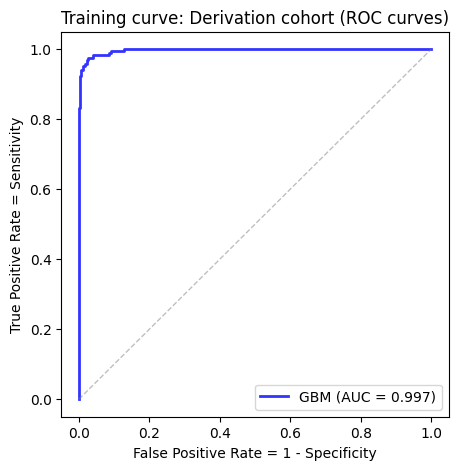

Training AUROC: 0.997 (95% CI: 0.995, 0.999)


In [11]:
# Predict on training data
pred_probas_train = gbm.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")

print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")


Val


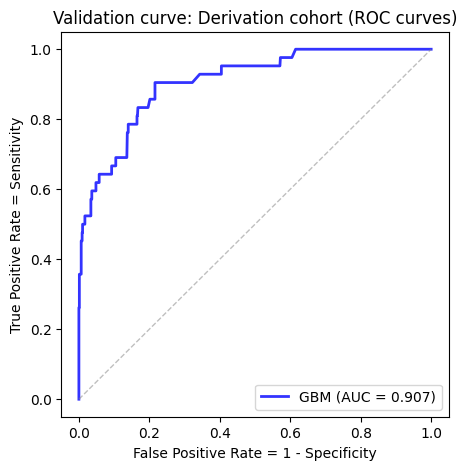

Val AUROC: 0.907 (95% CI: 0.856, 0.948)


In [12]:
# Evaluate on validation set
print("\nVal")
pred_probas_val = gbm.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Validation curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

print(f"Val AUROC: {roc_auc_val:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")

External Validation (Test)


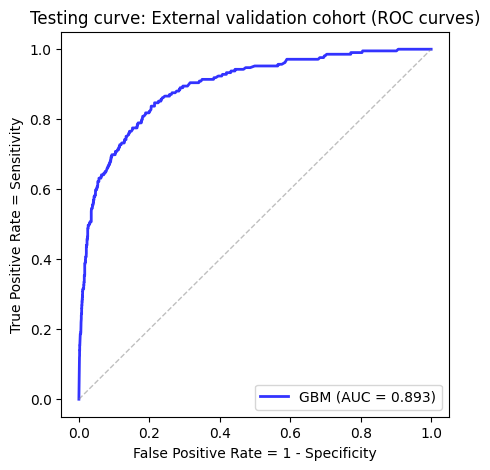

Val AUROC: 0.893 (95% CI: 0.868, 0.915)


In [20]:
print("External Validation (Test)")
pred_probas_test = gbm.predict_proba(X_test)
risk_groups_test = results(pred_probas_test)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probas_test[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: External validation cohort (ROC curves)')
#plot_Shapley(clf, X_test, columns, 'Derivation cohort', 25)
# Compute AUROC CI
auroc_ci_lower_test, auroc_ci_upper_test = bootstrap_metric_ci(y_test, pred_probas_test[:,1], "auroc")

print(f"Val AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_test:.3f}, {auroc_ci_upper_test:.3f})")